<a href="https://colab.research.google.com/github/suarezjw123/Machine-Learning-for-Online-Food-Delivery/blob/main/BA476Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BA 476 Group 9: Optimal Online Food Delivery**

**Members**: Leanne Tong, Maxim Zahra, Surabhi Srikanth, Jonathan Suarez, John Markowicz, Ryan Ko, Alyssa Nusantoro

In [ ]:
# import necessary libraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# splitting data into training and testing sets
# k-fold cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# compute MSE
from sklearn.metrics import mean_squared_error

# Linear Regression and Feature Selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

# KNN
from sklearn.neighbors import KNeighborsRegressor

# Lasso Model and Cross Validation
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

# Ridge Model and Cross Validation
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

# Elastic Net Model and Cross Validation
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

# Decision Tree Model and Cross Validation
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mount from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Cleaning

In [ ]:
# use the read_csv() function to read the original dataset
originalDF = pd.read_csv('/content/drive/My Drive/MLBA/Project/OriginalData.csv') # 'OriginalData.csv' is the same as 'Updated.csv'

print(originalDF.shape)
# (2442, 20)

originalDF.head()

(2442, 20)


,Unnamed: 0,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,1,0x4607_x,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30,11:45,4,0,2,3,3,0.0,1,3,24.0
1,2,0xb379_x,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45,19:50,3,1,2,3,4,1.0,1,1,33.0
2,3,0x20f7_x,BANGRES18DEL01,37,4.4,12.913041,77.683237,12.953041,77.723237,13:50,13:55,6,0,0,0,3,2.0,1,1,42.0
3,4,0x7804_x,HYDRES13DEL02,28,4.9,17.431477,78.400350,17.451477,78.420350,10:60,11:15,2,2,1,2,4,1.0,1,3,19.0
4,5,0x7faf_x,RANCHIRES07DEL01,37,4.6,23.359407,85.325055,23.429407,85.395055,23:50,23:60,3,2,0,2,3,1.0,1,1,25.0


In [ ]:
# cleaning the columns in the original data

# rename the columns
originalDF.columns = ['', 'ID', 'DeliveryPersonID', 'DeliveryPersonAge', 'DeliveryPersonRatings',
                     'RestaurantLatitude', 'RestaurantLongitude',
                     'DeliveryLocationLatitude', 'DeliveryLocationLongitude',
                     'TimeOrdered', 'TimeOrderPickedUp',
                     'WeatherCondition', 'RoadTrafficDensity', 'VehicleCondition',
                     'TypeOfOrder', 'VehicleType', 'MultipleDeliveries', 'Festival', 'City', 'TimeTaken(min)']


# remove unnecessary columns
# removed columns : '' / 'ID' / 'DeliveryPersonID' / 'Festival'

# keep the predictors that may potentially impact the response
keepColumns = ['DeliveryPersonAge', 'DeliveryPersonRatings', \
               'RestaurantLatitude', 'RestaurantLongitude', \
               'DeliveryLocationLatitude', 'DeliveryLocationLongitude', \
               'TimeOrdered', 'TimeOrderPickedUp', \
               'WeatherCondition', 'RoadTrafficDensity', 'VehicleCondition', \
               'TypeOfOrder', 'VehicleType', 'MultipleDeliveries', 'City',  'TimeTaken(min)']


# create a new dataframe with the cleaned columns
cleanColumnsDataframe = originalDF[keepColumns]
# create a new csv file with the cleaned columns
cleanColumnsDataframe.to_csv('/content/drive/My Drive/MLBA/Project/CleanedColumnsData.csv', index = False)

print(cleanColumnsDataframe.shape)
# (2442, 16)

(2442, 16)


In [ ]:
# cleaning the rows in the cleaned column data

# read the cleaned column dataset
cleanRowsDataframe = pd.read_csv('/content/drive/My Drive/MLBA/Project/CleanedColumnsData.csv')


# remove any row that contains a NaN value
cleanRowsDataframe = cleanRowsDataframe.dropna()

# remove any rows that contain a '0' value for 'RestaurantLatitude' or 'RestaurantLongitude'
cleanRowsDataframe = cleanRowsDataframe[(cleanRowsDataframe['RestaurantLatitude'] != 0) & (cleanRowsDataframe['RestaurantLongitude'] != 0)]



# display all unique values in the 'WeatherCondition' column
# print(cleanRowsDataframe['WeatherCondition'].unique())
# Windy - 6     Sunny - 4     Stormy - 3     Sandstorms - 2     Fog - 1     Cloudy - 0
cleanRowsDataframe['WeatherCondition'] = cleanRowsDataframe['WeatherCondition'].replace([0, 1, 2, 3, 4, 6], ['Cloudy', 'Fog', 'Sandstorms', 'Stormy', 'Sunny', 'Windy'])

# convert the categorical values in the 'WeatherCondition' column to numerical values
cleanRowsDataframe['WeatherCondition'] = cleanRowsDataframe['WeatherCondition'].map({'Sunny': 0, 'Cloudy': 1, 'Fog': 2, 'Windy': 3, 'Stormy': 4, 'Sandstorms': 5})



# display all unique values in the 'RoadTrafficDensity' column
# print(cleanRowsDataframe['RoadTrafficDensity'].unique())
# Medium - 3/3     Low - 2/2     Jam - 1/1     High - 0/0
cleanRowsDataframe['RoadTrafficDensity'] = cleanRowsDataframe['RoadTrafficDensity'].replace([0, 1, 2, 3], ['High', 'Jam', 'Low', 'Medium'])

# convert the categorical values in the 'RoadTrafficDensity' column to numerical values
cleanRowsDataframe['RoadTrafficDensity'] = cleanRowsDataframe['RoadTrafficDensity'].map({'Low': 0, 'Medium': 1, 'High': 2, 'Jam': 3})



# display all unique values in the 'TypeOfOrder' column
# print(cleanRowsDataframe['TypeOfOrder'].unique())
# Snack - 3     Drinks - 1     Meal - 2     Buffet - 0
cleanRowsDataframe['TypeOfOrder'] = cleanRowsDataframe['TypeOfOrder'].replace([0, 1, 2, 3], ['Buffet', 'Drinks', 'Meal', 'Snack'])

# convert the categorical values in the 'TypeOfOrder' column to numerical values
cleanRowsDataframe['TypeOfOrder'] = cleanRowsDataframe['TypeOfOrder'].map({'Snack': 0, 'Drinks': 1, 'Meal': 2, 'Buffet': 3})



# display all unique values in the 'VehicleType' column
# print(cleanRowsDataframe['VehicleType'].unique())
# Scooter - 3/4     Motorcycle - 2/3      ElectricScooter - 1/2
cleanRowsDataframe['VehicleType'] = cleanRowsDataframe['VehicleType'].replace([2, 3, 4], ['ElectricScooter', 'Motorcycle', 'Scooter'])

# convert the categorical values in the 'VehicleType' column to numerical values
cleanRowsDataframe['VehicleType'] = cleanRowsDataframe['VehicleType'].map({'Scooter': 0, 'ElectricScooter': 1, 'Motorcycle': 2})



# display all unique values in the 'City' column
# print(cleanRowsDataframe['City'].unique())
# Metropolitan - 0/1     Urban - 2/3     Semi-Urban - 1/4
cleanRowsDataframe['City'] = cleanRowsDataframe['City'].replace([1, 2, 3, 4], ['Metropolitan', '', 'Urban', 'Semi-Urban'])
cleanRowsDataframe = cleanRowsDataframe[cleanRowsDataframe['City'] != '']

# convert the categorical values in the 'City' column to numerical values
cleanRowsDataframe['City'] = cleanRowsDataframe['City'].map({'Semi-Urban': 0, 'Urban': 1, 'Metropolitan': 2})



cleanDF = cleanRowsDataframe
# create a new csv file with the cleaned columns and rows
cleanDF.to_csv('/content/drive/My Drive/MLBA/Project/CleanedData.csv', index = False)

# Functions to Convert Data Values

In [ ]:
# convert time format of (hour:minute:seconds) or (hour:minute) to decimal (float) format

def decimalTime(t):
  components = t.split(':')

  # check if the time format is (hour:minute)
  if len(components) == 2:
    hour, minute, second = int(components[0]), int(components[1]), 0
  # check if the time format is (hour:minute:seconds)
  elif len(components) == 3:
    hour, minute, second = map(int, components)
  else:
    raise ValueError("ERROR: Invalid Time Format")

  decimalTime = hour + (minute / 100) + second

  return decimalTime

In [ ]:
# compute the location distance from the restaurant to the delivery location

def distance(restaurantLat, restaurantLong, deliveryLat, deliveryLong):
  # radius of the Earth in kilometers
  earthRadius = 6371

  # convert latitude and longitude from degrees to radians
  restaurantLat, restaurantLong, deliveryLat, deliveryLong = map(math.radians, [restaurantLat, restaurantLong, deliveryLat, deliveryLong])

  # implement the Haversine formula
  # an accurate way of computing distances b/t two points on the surface of a sphere using lat. and long. of the two points
  distanceLat = deliveryLat - restaurantLat
  distanceLong = deliveryLong - restaurantLong
  a = math.sin(distanceLat/2)**2 + math.cos(restaurantLat) * math.cos(deliveryLat) * math.sin(distanceLong/2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
  distance = earthRadius * c

  # return value is the distance between the locations in kilometers
  return distance

In [ ]:
# read the final cleaned dataset
df = pd.read_csv('/content/drive/My Drive/MLBA/Project/CleanedData.csv')

# create a new column for the dataframe that represents the distance b/t the restaurant and the delivery location
df['Distance(km)'] = df.apply(lambda row: distance(row['RestaurantLatitude'], row['RestaurantLongitude'], row['DeliveryLocationLatitude'], row['DeliveryLocationLongitude']), axis=1)

# convert the timestamps into floats
df['TimeOrdered'] = df['TimeOrdered'].apply(decimalTime)
df['TimeOrderPickedUp'] = df['TimeOrderPickedUp'].apply(decimalTime)

print(df.shape)
# (2118, 17)

(2118, 17)


# Categorical Columns

In [ ]:
# convert the numerical values in the 'WeatherCondition' column to categorical values
df['WeatherCondition'] = df['WeatherCondition'].map({0: 'Sunny', 1: 'Cloudy', 2: 'Fog', 3: 'Windy', 4: 'Stormy', 5: 'Sandstorms'})

# convert the numerical values in the 'RoadTrafficDensity' column to categorical values
df['RoadTrafficDensity'] = df['RoadTrafficDensity'].map({0: 'Low', 1: 'Medium', 2: 'High', 3: 'Jam'})

# convert the numerical values in the 'TypeOfOrder' column to categorical values
df['TypeOfOrder'] = df['TypeOfOrder'].map({0: 'Snack', 1: 'Drinks', 2: 'Meal', 3: 'Buffet'})

# convert the numerical values in the 'VehicleType' column to categorical values
df['VehicleType'] = df['VehicleType'].map({0: 'Scooter', 1: 'ElectricScooter', 2: 'Motorcycle'})

# convert the numerical values in the 'City' column to categorical values
df['City'] = df['City'].map({0: 'Semi-Urban', 1: 'Urban', 2: 'Metropolitan'})

# Dummy Variables for Categorical Columns

In [ ]:
# create six new columns for the dataframe that represent each weather condition
weatherDummy = pd.get_dummies(df['WeatherCondition'], drop_first = True, dtype = int)
df[weatherDummy.columns] = weatherDummy

# create four new columns for the dataframe that represent each road traffic density
trafficDummy = pd.get_dummies(df['RoadTrafficDensity'], drop_first = True, dtype = int)
df[trafficDummy.columns] = trafficDummy

# create four new columns for the dataframe that represent each type of order
orderDummy = pd.get_dummies(df['TypeOfOrder'], drop_first = True, dtype = int)
df[orderDummy.columns] = orderDummy

# create three new columns for the dataframe that represent each vehicle type
vehicleDummy = pd.get_dummies(df['VehicleType'], drop_first = True, dtype = int)
df[vehicleDummy.columns] = vehicleDummy

# create three new columns for the dataframe that represent each city
cityDummy = pd.get_dummies(df['City'], drop_first = True, dtype = int)
df[cityDummy.columns] = cityDummy

df.describe()

,DeliveryPersonAge,DeliveryPersonRatings,RestaurantLatitude,RestaurantLongitude,DeliveryLocationLatitude,DeliveryLocationLongitude,TimeOrdered,TimeOrderPickedUp,VehicleCondition,MultipleDeliveries,...,Jam,Low,Medium,Drinks,Meal,Snack,Motorcycle,Scooter,Semi-Urban,Urban
count,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,...,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000,2118.000000
mean,29.505194,4.625921,18.659478,76.952103,18.920712,77.016461,18.098182,18.273536,0.968839,0.756846,...,0.328140,0.336166,0.232767,0.252597,0.240321,0.251180,0.597734,0.330500,0.023607,0.234655
std,5.706879,0.311841,6.090310,3.556569,5.451263,3.556545,4.444545,4.447888,0.814936,0.553161,...,0.469647,0.472508,0.422695,0.434604,0.427379,0.433794,0.490471,0.470504,0.151858,0.423883
min,20.000000,2.500000,-30.902872,72.768726,9.980846,72.778726,8.100000,8.150000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,4.500000,12.981615,73.896485,13.065697,73.937313,16.362500,16.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,4.700000,19.055831,76.619103,19.123649,76.671094,19.300000,19.400000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,34.000000,4.800000,22.745536,78.347554,22.812133,78.389645,21.400000,21.500000,2.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,39.000000,5.000000,30.914057,88.433452,31.035562,88.503310,23.600000,24.150000,2.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Split the Data into Training Set and Testing Set

In [ ]:
# define predictors with dummy variables (subject to change)
predictors = df[['DeliveryPersonAge', 'DeliveryPersonRatings', \
               'TimeOrdered', 'TimeOrderPickedUp', \
               'Sunny', 'Fog', 'Windy', 'Stormy', 'Sandstorms', \
               # 'Cloudy'
               'Low', 'Medium', 'Jam', \
               # 'High'
               'VehicleCondition', \
               # 'Good', 'Average', 'Bad', \
               'Snack', 'Drinks', 'Meal', \
               # 'Buffet'
               'Scooter', 'Motorcycle', \
               # 'ElectricScooter'
               'MultipleDeliveries', \
               # 'NoMultipleDeliveries', 'OneMultipleDeliveries', 'TwoMultipleDeliveries', 'ThreeMultipleDeliveries', \
               'Semi-Urban', 'Urban', \
               # 'Metropolitan'
               'Distance(km)']]

# define our response variable
outcome = df['TimeTaken(min)']

# randomly split the dataset into training sets and testing sets
X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, train_size = 0.80)

print(X_train.shape, y_train.shape)
# (1694, 22) (1694,)

(1694, 22) (1694,)


In [ ]:
# create a csv file that contains the training sets
X_train.to_csv('/content/drive/My Drive/MLBA/Project/X_train.csv', index = False)

# create a csv file that contains the testing sets
X_test.to_csv('/content/drive/My Drive/MLBA/Project/X_test.csv', index = False)

# same for y training set and y testing set
y_train.to_csv('/content/drive/My Drive/MLBA/Project/y_train.csv', index = False)
y_test.to_csv('/content/drive/My Drive/MLBA/Project/y_test.csv', index = False)

In [ ]:
# read the csv files that contains the training sets and testing sets

X_train = pd.read_csv('/content/drive/My Drive/MLBA/Project/X_train.csv')
X_test = pd.read_csv('/content/drive/My Drive/MLBA/Project/X_test.csv')

y_train = pd.read_csv('/content/drive/My Drive/MLBA/Project/y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/MLBA/Project/y_test.csv')

# Training a Baseline Naive Model

In [ ]:
# obtain the average of all of the observed outcomes (as the baseline)
y_naive_hat = y_train.mean()

# create an array of ones that is the size of y_train set, in which each element is then multiplied by the value of average observed outcome
y_naive_hat_train = np.ones_like(y_train) * y_naive_hat
y_naive_hat_test = np.ones_like(y_test) * y_naive_hat

# compute the MSE for the baseline training set and the baseline testing set
mse_naive_train = mean_squared_error(y_train, y_naive_hat_train)
mse_naive_test = mean_squared_error(y_test, y_naive_hat_test)

# baseline MSE should be higher than that obtained from any model
print("Baseline Naive MSE Train:", mse_naive_train)
print("Baseline Naive MSE Test:", mse_naive_test)
print()
print("Baseline Naive RMSE Train:", math.sqrt(mse_naive_train))
print("Baseline Naive RMSE Test:", math.sqrt(mse_naive_test))

Baseline Naive MSE Train: 85.6490621110134
Baseline Naive MSE Test: 86.19955453820361

Baseline Naive RMSE Train: 9.25467785020167
Baseline Naive RMSE Test: 9.284371520905635


# Linear Regression Model

In [ ]:
# instantiate a linear regression model
linearRegModel = LinearRegression(fit_intercept = True)

# fit the linear regression model to the training data
linearRegModel.fit(X_train, y_train)

# display the coefficients and intercept
# linearRegModel.coef_, linearRegModel.intercept_


# make predictions on the training set
y_train_hat_lr = linearRegModel.predict(X_train)

# evaluate the mean squared error on the training predictions
mse_train_lr = mean_squared_error(y_train, y_train_hat_lr)

# make predictions on the testing set
y_test_hat_lr = linearRegModel.predict(X_test)

# evaluate the mean squared error on the testing predictions
mse_test_lr = mean_squared_error(y_test, y_test_hat_lr)

print("Linear Regression MSE Train:", mse_train_lr)
print("Linear Regression MSE Test:", mse_test_lr)
print()
print("Linear Regression RMSE Train:", math.sqrt(mse_train_lr))
print("Linear Regression RMSE Test:", math.sqrt(mse_test_lr))

Linear Regression MSE Train: 37.93325504833683
Linear Regression MSE Test: 38.22836186475125

Linear Regression RMSE Train: 6.158997893191459
Linear Regression RMSE Test: 6.182908851402489


# Stepwise Feature Selection

Note that the MSE for the training set and the testing set after variable selection may be higher than that before variable selection due to information loss. In other words, we are not using all of the predictors in the model to fit the data, only a subset of the predictors.

## Forward Selection

In [ ]:
# forward selection for features
# initialize stepwise feature selection for forward selection
sfs_forward = SequentialFeatureSelector(linearRegModel, direction = "forward").fit(X_train, y_train)
predictors_forward = sfs_forward.get_feature_names_out()

print(predictors_forward)

['DeliveryPersonAge' 'DeliveryPersonRatings' 'Sunny' 'Fog' 'Stormy' 'Low'
 'Jam' 'VehicleCondition' 'MultipleDeliveries' 'Semi-Urban' 'Urban']


In [ ]:
# using the predictors chosen from forward selection
X_train_forward = X_train[predictors_forward]
X_test_forward = X_test[predictors_forward]

# fit the linear regression model with the forward-selected features
linearRegModel.fit(X_train_forward, y_train)

# make predictions on the training set
y_train_forward_hat = linearRegModel.predict(X_train_forward)

# evaluate the mean squared error on the training predictions
mse_train_forward = mean_squared_error(y_train, y_train_forward_hat)

# make predictions on the testing set
y_test_forward_hat = linearRegModel.predict(X_test_forward)

# evaluate the mean squared error on the testing predictions
mse_test_forward = mean_squared_error(y_test, y_test_forward_hat)

print("MSE Train Forward:", mse_train_forward)
print("MSE Test Forward:", mse_test_forward)
print()
print("RMSE Train Forward:", math.sqrt(mse_train_forward))
print("RMSE Test Forward:", math.sqrt(mse_test_forward))

MSE Train Forward: 39.25529781035853
MSE Test Forward: 38.934705220459314

RMSE Train Forward: 6.2654048401008
RMSE Test Forward: 6.239768042199911


## Backward Selection

In [ ]:
# backward selection for features

sfs_backward = SequentialFeatureSelector(linearRegModel, direction = "backward").fit(X_train, y_train)
predictors_backward = sfs_backward.get_feature_names_out()

print(predictors_backward)

['DeliveryPersonAge' 'DeliveryPersonRatings' 'Sunny' 'Windy' 'Stormy'
 'Sandstorms' 'Low' 'Jam' 'VehicleCondition' 'MultipleDeliveries' 'Urban']


In [ ]:
# using the predictors chosen from backward selection
X_train_backward = X_train[predictors_backward]
X_test_backward = X_test[predictors_backward]

# fit the linear regression model with the backward-selected features
linearRegModel.fit(X_train_backward, y_train)

# make predictions on the training set
y_train_backward_hat = linearRegModel.predict(X_train_backward)

# evaluate the mean squared error on the training predictions
mse_train_backward = mean_squared_error(y_train, y_train_backward_hat)

# make predictions on the testing set
y_test_backward_hat = linearRegModel.predict(X_test_backward)

# evaluate the mean squared error on the testing predictions
mse_test_backward = mean_squared_error(y_test, y_test_backward_hat)

print("MSE Train Backward:", mse_train_backward)
print("MSE Test Backward:", mse_test_backward)
print()
print("RMSE Train Backward:", math.sqrt(mse_train_backward))
print("RMSE Test Backward:", math.sqrt(mse_test_backward))

MSE Train Backward: 39.39377246166859
MSE Test Backward: 38.60379303763012

RMSE Train Backward: 6.276445846310521
RMSE Test Backward: 6.213195074808944


# KNN

K-nearest neighbors regression is a non-parametric method, which does not explicity assume a parametric form for the model, and thereby provide an alternative and more flexible approach for performing regression.

n_neighbors: 1, Average MSE: 72.04986472569863
n_neighbors: 2, Average MSE: 53.782431795569984
n_neighbors: 3, Average MSE: 46.833863763748035
n_neighbors: 4, Average MSE: 45.694270042415035
n_neighbors: 5, Average MSE: 43.91283936394896
n_neighbors: 6, Average MSE: 43.977624369932066
n_neighbors: 7, Average MSE: 43.33004517930124
n_neighbors: 8, Average MSE: 42.09225309167234
n_neighbors: 9, Average MSE: 43.98722075365295
n_neighbors: 10, Average MSE: 42.137053446440106
n_neighbors: 11, Average MSE: 42.36411589318329
n_neighbors: 12, Average MSE: 42.40618972051068
n_neighbors: 13, Average MSE: 42.42013083005385
n_neighbors: 14, Average MSE: 41.770683271475846
n_neighbors: 15, Average MSE: 41.87273889441622
n_neighbors: 16, Average MSE: 42.151255160060046
n_neighbors: 17, Average MSE: 41.953775471174026
n_neighbors: 18, Average MSE: 41.90619643035308
n_neighbors: 19, Average MSE: 42.39401124675691
n_neighbors: 20, Average MSE: 42.20738243354104
Optimal Number of Neighbors: 14

Test MSE

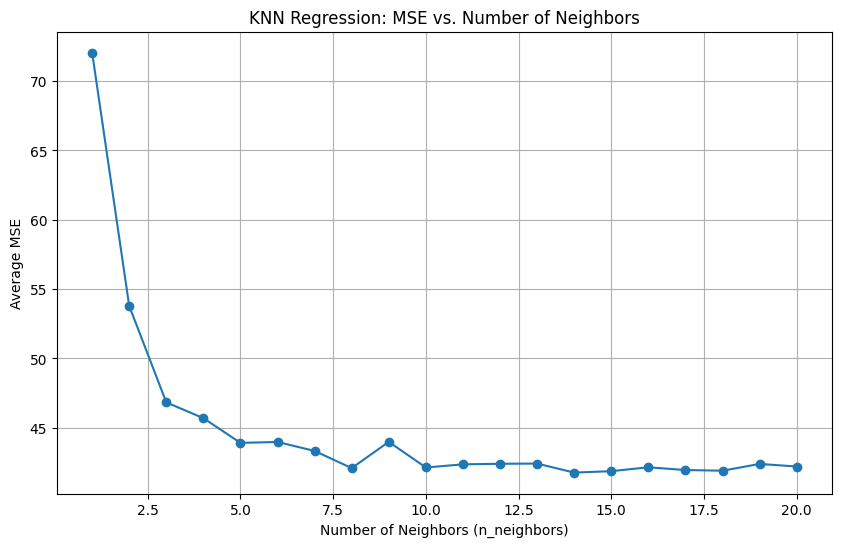

In [ ]:
# set the number of folds for cross-validation (5)
n_folds = 5
kf = KFold(n_splits = n_folds, shuffle = True)

neighbor_settings = range(1, 21) # range of neighbors to try

avg_scores = [] # list to store the average MSE for each value of K

# implement the loop for KNN regression with cross-validation
for n_neighbors in neighbor_settings:
    # pipeline with standardization and KNN regression
    knn_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = n_neighbors))
    # compute the MSE for each fold
    scores = cross_val_score(knn_pipeline, X_train, y_train, cv = kf, scoring = 'neg_mean_squared_error')

    avg_mse = np.mean(-scores)
    avg_scores.append(avg_mse)

    print(f"n_neighbors: {n_neighbors}, Average MSE: {avg_mse}")

# obtain the optimal number of neighbors
optimal_n_neighbors = neighbor_settings[np.argmin(avg_scores)]
print(f"Optimal Number of Neighbors: {optimal_n_neighbors}")

knn_pipeline_optimal = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = optimal_n_neighbors))
knn_pipeline_optimal.fit(X_train, y_train)

test_mse = mean_squared_error(y_test, knn_pipeline_optimal.predict(X_test))
print()
print("Test MSE:", test_mse)
print("Test RMSE:", math.sqrt(test_mse))
print()
# print("Optimal Number of Neighbors for Test:", optimal_n_neighbors)

plt.figure(figsize = (10, 6))
plt.plot(neighbor_settings, avg_scores, marker = 'o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Average MSE')
plt.title('KNN Regression: MSE vs. Number of Neighbors')
plt.grid(True)
plt.show()

# Regularized Regression

Our regularized regression models will include Lasso, Ridge, and Elastic Nets. A regularized regression puts constraints on the magnitude of the coefficients in the model.

## Lasso Regression Model

In [ ]:
# standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# create LASSO CV model
lasso_cv = LassoCV(cv = 5, alphas = np.logspace(-4, 4, 100))
lasso_cv.fit(X_train_std, y_train)

# get the optimal alpha
optimal_alpha = lasso_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

# apply the optimal alpha to LASSO model
lasso = Lasso(alpha = optimal_alpha)
lasso.fit(X_train_std, y_train)

# make the predictions
y_test_pred = lasso.predict(X_test_std)
y_train_pred = lasso.predict(X_train_std)

# evaluate performance (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE (Train):", mse_train)
print("MSE (Test):", mse_test)
print()
print("RMSE (Train):", math.sqrt(mse_train))
print("RMSE (Test):", math.sqrt(mse_test))
print()
print("LASSO Coefficients:", lasso.coef_)

Optimal Alpha: 0.04641588833612782
MSE (Train): 38.023176789248495
MSE (Test): 38.18914125116932

RMSE (Train): 6.166293602258045
RMSE (Test): 6.17973634155773

LASSO Coefficients: [ 2.03577208 -2.67468167  0.          0.58231321 -2.18816885  0.60731245
 -0.78138522 -0.93153802 -0.74206792 -2.69310173 -0.53787564  1.18286104
 -1.60469024  0.37725954 -0.          0.         -0.06376334 -0.
  1.84532684 -0.76885464 -0.88619991 -0.13400636]


### 100 Different Lasso Regression Models with Lambdas

In [ ]:

num_lambdas = 100
lambdas = np.logspace(-4, 4, num_lambdas)

y_train_hat = np.zeros((y_train.shape[0], num_lambdas))
y_test_hat = np.zeros((y_test.shape[0], num_lambdas))
coefficients = np.zeros((X_train.shape[1], num_lambdas))

# Create LASSO model
for i, current_lambda in enumerate(lambdas):
  lasso = Lasso(alpha=current_lambda)
  lasso.fit(X_train_std, y_train)

  X_train_pred = lasso.predict(X_train_std)
  X_test_pred = lasso.predict(X_test_std)

  y_train_hat[:,i] = X_train_pred
  y_test_hat[:,i] = X_test_pred
  coefficients[:,i] = lasso.coef_

### Strongest Predictors for Lasso Regression

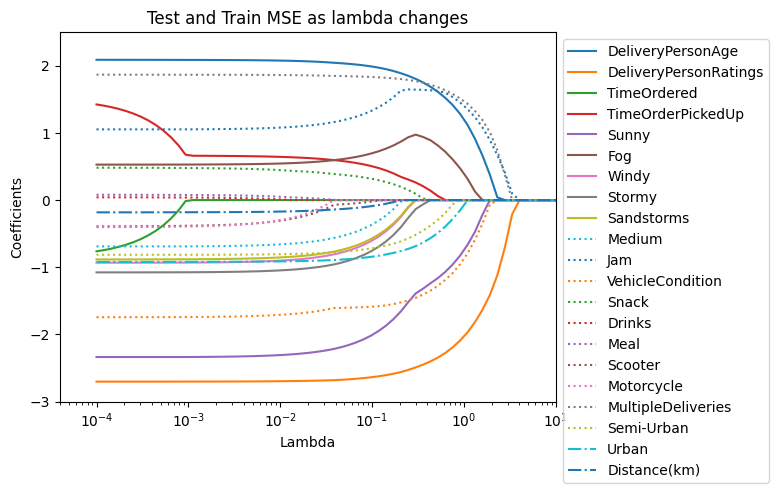

In [ ]:
num_predictors = X_train_std.shape[1]

plt.title("Test and Train MSE as lambda changes")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.xscale("log")

# for i in range(num_predictors):
#   plt.plot(..., ..., label=...)

for i in range(9):
    plt.plot(lambdas, coefficients[i],label = X_train.columns[i])

for i in range(10, 20):
    plt.plot(lambdas, coefficients[i],label = X_train.columns[i], linestyle=":")

for i in range(20, 22):
    plt.plot(lambdas, coefficients[i],label = X_train.columns[i], linestyle="-.")


# Set y-axis limits
plt.ylim(-3, 2.5)
plt.xlim(-10000, 10)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

## Ridge Regression Model

In [ ]:
# standardize the data
scaler = StandardScaler()
X1_std_train = scaler.fit_transform(X_train)
X1_std_test = scaler.transform(X_test)

print(X1_std_train[:,:].std(axis=0), X1_std_train[:,:].mean(axis=0))
print(X1_std_test[:,:].std(axis=0), X1_std_test[:,:].mean(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-2.56911113e-16  1.39885480e-15  1.40514650e-16 -6.29170073e-17
 -2.30695693e-17 -2.09723358e-18 -5.97711569e-17 -3.67015876e-17
  5.45280730e-17 -1.10104763e-16  1.46806350e-17 -3.56529708e-17
 -8.80838102e-17 -7.13059416e-17  3.35557372e-17 -4.08960547e-17
 -2.93612701e-17 -4.19446715e-18  7.96948759e-17 -1.25834015e-17
 -3.72258960e-17 -8.38893431e-18]
[0.99329415 0.92955012 1.04972753 1.05017453 1.04786924 1.06332318
 0.90436278 1.03866662 0.92297375 1.01942025 0.95560721 0.96497834
 1.00280526 1.03207732 0.96352066 1.02900845 0.97582582 0.98318937
 1.00398697 0.93791719 1.06384195 1.34409915] [-0.07652919  0.0290111  -0.04242589 -0.0420629   0.05425485  0.07230685
 -0.09901813  0.04531021 -0.08272768  0.05933414 -0.06707143 -0.08819019
  0.00801214  0.05818237 -0.06133985  0.04932397 -0.06323293  0.07531845
 -0.02616416 -0.01936928  0.10941205  0.04941535]


In [ ]:
# create Ridge CV model
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
clf.score(X_train, y_train)

0.5570931590573455

In [ ]:
ridgecv = RidgeCV(cv = 5, alphas = np.logspace(-4,4,100))
ridgecv.fit(X1_std_train, y_train)
optimal_alpha = ridgecv.alpha_
print("Optimal Alpha", optimal_alpha)

Optimal Alpha 31.257158496882415


In [ ]:
ridge = Ridge(alpha = optimal_alpha)
# fit the model to the training data
ridge.fit(X1_std_train, y_train)

# display the coefficients
ridge.coef_

array([ 2.04935935, -2.66351957,  0.24961851,  0.38019975, -2.24124671,
        0.58280564, -0.85411374, -0.99958143, -0.81122705, -2.71912891,
       -0.59068358,  1.15487652, -1.68863201,  0.45717193,  0.03005198,
        0.06757278, -0.32808384, -0.3045738 ,  1.85112503, -0.80511849,
       -0.9123446 , -0.18042814])

In [ ]:
# make predictions on the training set
y_train_fit_ridge = ridge.predict(X1_std_train)
mse_train_ridge = mean_squared_error(y_train, y_train_fit_ridge)

print("MSE (Train):", mse_train_ridge)
print("RMSE (Train):", math.sqrt(mse_train_ridge))

MSE (Train): 37.95717199406947
RMSE (Train): 6.16093921363208


In [ ]:
# make predictions on the testing set
y_test_fit_ridge = ridge.predict(X1_std_test)
mse_test_ridge = mean_squared_error(y_test, y_test_fit_ridge)

print("MSE (Test):", mse_test_ridge)
print("RMSE (Test):", math.sqrt(mse_test_ridge))

MSE (Test): 38.267136587370125
RMSE (Test): 6.186043694266161


## Elastic Nets Model

In [ ]:
# standardize the data
scaler = StandardScaler()
X_std_train = scaler.fit_transform(X_train)
X_std_test = scaler.transform(X_test)

print(X_std_train[:,:].std(axis=0), X_std_train[:,:].mean(axis=0))
print(X_std_test[:,:].std(axis=0), X_std_test[:,:].mean(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-2.56911113e-16  1.39885480e-15  1.40514650e-16 -6.29170073e-17
 -2.30695693e-17 -2.09723358e-18 -5.97711569e-17 -3.67015876e-17
  5.45280730e-17 -1.10104763e-16  1.46806350e-17 -3.56529708e-17
 -8.80838102e-17 -7.13059416e-17  3.35557372e-17 -4.08960547e-17
 -2.93612701e-17 -4.19446715e-18  7.96948759e-17 -1.25834015e-17
 -3.72258960e-17 -8.38893431e-18]
[0.99329415 0.92955012 1.04972753 1.05017453 1.04786924 1.06332318
 0.90436278 1.03866662 0.92297375 1.01942025 0.95560721 0.96497834
 1.00280526 1.03207732 0.96352066 1.02900845 0.97582582 0.98318937
 1.00398697 0.93791719 1.06384195 1.34409915] [-0.07652919  0.0290111  -0.04242589 -0.0420629   0.05425485  0.07230685
 -0.09901813  0.04531021 -0.08272768  0.05933414 -0.06707143 -0.08819019
  0.00801214  0.05818237 -0.06133985  0.04932397 -0.06323293  0.07531845
 -0.02616416 -0.01936928  0.10941205  0.04941535]


In [ ]:
elnet = ElasticNet(l1_ratio = 0.5)

# fit the model to the training data
elnet.fit(X_std_train, y_train)

# make the predictions on the train and test sets
y_train_fit_elnet = elnet.predict(X_std_train)
y_test_fit_elnet = elnet.predict(X_std_test)

# compute the MSE
mse_train_elnet = mean_squared_error(y_train, y_train_fit_elnet)
mse_test_elnet = mean_squared_error(y_test, y_test_fit_elnet)


# print(np.sqrt(mse_test_elnet), mse_train_elnet, mse_test_elnet)

print("RMSE (Train):", math.sqrt(mse_train_elnet))
print("MSE (Train):", mse_train_elnet)
print()
print("RMSE (Test):", math.sqrt(mse_test_elnet))
print("MSE (Test):", mse_test_elnet)

RMSE (Train): 6.826553248299238
MSE (Train): 46.60182925186488

RMSE (Test): 6.840408157904291
MSE (Test): 46.79118376672357


In [ ]:
elnet_cv = ElasticNetCV(alphas=[0.01, 0.1, 1.0, 10.0], l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99, 1], cv=5)

# fit the model to the training data
elnet_cv.fit(X_std_train, y_train)

# get the best alpha and l1_ratio values
best_alpha = elnet_cv.alpha_
best_l1_ratio = elnet_cv.l1_ratio_

# make predictions on CV model
y_train_fit_elnet_cv = elnet_cv.predict(X_std_train)
y_test_fit_elnet_cv= elnet_cv.predict(X_std_test)

# evaluate performance (MSE)
mse_train_elnet_cv = mean_squared_error(y_train, y_train_fit_elnet_cv)
mse_test_elnet_cv = mean_squared_error(y_test, y_test_fit_elnet_cv)

print(f"Best aAlpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")
print(f"MSE Train: {mse_train_elnet_cv}")
print(f"MSE Test: {mse_test_elnet_cv}")
print(f"RMSE Test: {math.sqrt(mse_test_elnet_cv)}")
print(f"Percentage Change in MSE Test:",(((mse_test_elnet_cv - mse_test_elnet)/mse_test_elnet) * 100),"%")

Best aAlpha: 0.01
Best l1_ratio: 0.01
MSE Train: 37.94305442334653
MSE Test: 38.233723657113416
RMSE Test: 6.183342434081539
Percentage Change in MSE Test: -18.288616403195068 %


# Ensemble Methods

Random Forests, Bagging, and Boosting are ensemble methods, in which the overall model fit is produced from many regression trees.

## Random Forests

### Decision Tree

In [ ]:
# instantiate the decision tree
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train)
tree_hat = dt.predict(X_test)
print(mean_squared_error(y_test, tree_hat))

37.405660377358494


### Naive Random Forest

In [ ]:
# create a naive random forest model
rf_naive = RandomForestRegressor(n_jobs = -1)

# fit the model to the training data
rf_naive = RandomForestRegressor()
rf_naive.fit(X_train,y_train)
yhat_train = rf_naive.predict(X_train)
yhat_naive = rf_naive.predict(X_test)

print("RMSE (Train):", math.sqrt(mean_squared_error(y_train, yhat_train)))
print("MSE (Train):", mean_squared_error(y_train, yhat_train))
print()
print("RMSE (Test):", math.sqrt(mean_squared_error(y_test, yhat_naive)))
print("MSE (Test):", mean_squared_error(y_test, yhat_naive))

RMSE (Train): 1.7705488780030545
MSE (Train): 3.134843329397875

RMSE (Test): 4.605037950799308
MSE (Test): 21.206374528301886


### Random Forest Tuning

In [ ]:
max_depth = max_depth = list(range(20,81,10)) # max depth of the tree
max_depth.append(None)
min_samples_split = [2,3,5] # minimum number of samples required to split a node

param_grid ={
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
}

# cross validation
rf_cv = GridSearchCV(estimator = RandomForestRegressor(max_features = int((X_train.shape[1])//2), n_estimators = 500),
                      param_grid = param_grid,
                      scoring = "neg_mean_squared_error")
rf_cv.fit(X_train,y_train) # fit the model to the training data
yhat_cv = rf_cv.predict(X_test) # make predictions on the testing set

print("MSE (Test):", mean_squared_error(y_test, yhat_cv))
print("RMSE (Test):", math.sqrt(mean_squared_error(y_test, yhat_cv)))
print(rf_cv.best_params_)

MSE (Test): 20.819203915094338
RMSE (Test): 4.562806583134369
{'max_depth': 50, 'min_samples_split': 2}


### Feature Importance Plot

In [ ]:
rf_plt = RandomForestRegressor(n_estimators = 500, max_features = int((X_train.shape[1])//2), **rf_cv.best_params_)
rf_plt.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, max_features=11, n_estimators=500)

Text(0.5, 1.0, 'Feature Importance Plot')

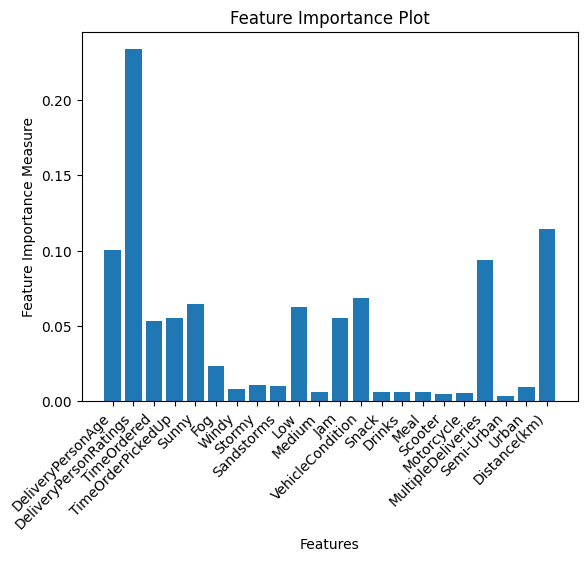

In [ ]:
col_names = X_train.columns.tolist() # list of column names
feature_importances = rf_plt.feature_importances_ # feature importance

plt.bar(col_names,feature_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance Measure')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Plot')

## Boosting

In [ ]:
rf_boost = RandomForestRegressor(n_estimators = 500, max_features = int((X_train.shape[1])//2), **rf_cv.best_params_)
boost_regr = AdaBoostRegressor(rf_boost) # boosting model
boost_regr.fit(X_train, y_train) # fit the model to the training data
yhat_boost = boost_regr.predict(X_test) # make predictions on the testing set

print("RMSE (Test):", math.sqrt(mean_squared_error(y_test, yhat_boost)))
print("MSE (Test):", mean_squared_error(y_test, yhat_boost))

RMSE (Test): 4.466647332056807
MSE (Test): 19.95093838897019


In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [130,150,180],
}

# cross validation (5-fold) for boosting
boost_cv = GridSearchCV(estimator = boost_regr, param_grid = param_grid, scoring="neg_mean_squared_error")

# fit the boosting model
boost_cv.fit(X_train, y_train)
# make predictions
yhat_boost = boost_cv.predict(X_test)
print("MSE (Test):", mean_squared_error(y_test, yhat_boost))
print("RMSE (Test):", math.sqrt(mean_squared_error(y_test, yhat_boost)))
print(boost_cv.best_params_)

MSE (Test): 19.96630611041986
RMSE (Test): 4.4683672756858135
{'learning_rate': 0.1, 'n_estimators': 180}


## Bagging

In [ ]:
bag_naive = BaggingRegressor(max_features = X_train.shape[1]) # instantiate the naive bagging model
bag_naive.fit(X_train, y_train) # fit to the training data
yhat_bag_naive = bag_naive.predict(X_test) # make predictions

print("RMSE (Naive):", math.sqrt(mean_squared_error(y_test, yhat_bag_naive)))
print("MSE (Naive):", mean_squared_error(y_test, yhat_bag_naive))

RMSE (Naive): 4.776606220019825
MSE (Naive): 22.815966981132078


### Tuning Bagged Model

In [ ]:
bag_grid = {
    'n_estimators':[int(x) for x in list(range(170, 301, 10))],
    'max_features': [0.5, 0.7, 0.9],

}

# cross validation
bag_cv = GridSearchCV(BaggingRegressor(), param_grid = bag_grid, scoring = "neg_mean_squared_error")

# fitting the model
bag_cv.fit(X_train, y_train)
# make predictions
yhat_bag = bag_cv.predict(X_test)

print(bag_cv.best_params_)
print()
print("RMSE (Test):", math.sqrt(mean_squared_error(y_test, yhat_bag)))
print("MSE (Test):", mean_squared_error(y_test, yhat_bag))

{'max_features': 0.9, 'n_estimators': 260}

RMSE (Test): 4.550069877026686
MSE (Test): 20.703135885825642


### Bagging with Out of Bag Error

In [ ]:
OOB_bag = BaggingRegressor(**bag_cv.best_params_, oob_score = True)
OOB_bag.fit(X_train, y_train)
yhat_OOB = OOB_bag.predict(X_test)
print("MSE (Test):", mean_squared_error(y_test, yhat_OOB))
print("RMSE (Test):", math.sqrt(mean_squared_error(y_test, yhat_OOB)))

MSE (Test): 20.49463617065486
RMSE (Test): 4.527100194457249


### MSE Graph for Ensemble Models

In [ ]:
trees = [int(x) for x in np.linspace(10, 300, 30)]
mse_boost = []
mse_bag = []
mse_rfnaive = []
mse_rf_tuned = []

for t in trees:
    boost_plt = AdaBoostRegressor(base_estimator = RandomForestRegressor(n_estimators= 500, max_features = int((X_train.shape[1])//2), **rf_cv.best_params_ ),  n_estimators = t) # **boost_cv.best_params_
    boost_plt.fit(X_train, y_train)
    mse_boost.append(mean_squared_error(y_test, boost_plt.predict(X_test)))

    br_plt = BaggingRegressor(oob_score = True, n_estimators = t, max_features = 0.9)
    br_plt.fit(X_train, y_train)
    mse_bag.append(mean_squared_error(y_test,br_plt.predict(X_test)))

    rf = RandomForestRegressor(n_estimators = t, max_features = int((X_train.shape[1])//2), **rf_cv.best_params_)
    rf.fit(X_train, y_train)
    mse_rf_tuned.append(mean_squared_error(y_test, rf.predict(X_test)))

    rf_naive = RandomForestRegressor(n_estimators = t)
    rf_naive.fit(X_train, y_train)
    mse_rfnaive.append(mean_squared_error(y_test, rf_naive.predict(X_test)))

In [ ]:
plt.plot(trees, mse_boost, label = 'Boosting RF')
plt.plot(trees, mse_bag, label = 'Bagging OOB')
plt.plot(trees, mse_rfnaive, label = 'RF Naive')
plt.plot(trees, mse_rf_tuned, label = 'RF Tuned')
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('MSE')
plt.title('MSE as a Function of Number of Trees')

# Model Plots

In [ ]:
x = ["Naive", "KNN",
     "Forward Selection", "Backward Selection",
     "Ridge", "Elastic Nets", "Linear Regression", "Lasso",
     "Random Forests"]

y = [9.284371520905635, 6.360971885102549,
     6.239768042199911, 6.213195074808944,
     6.186043694266161, 6.183342434081539, 6.182908851402489, 6.17973634155773,
     4.562806583134369]

plt.bar(x,y,color="red")
plt.xticks(x, rotation='vertical')

plt.xlabel("Test Root Mean Squared Error")
plt.ylabel("Model Name")
plt.title("Test RMSE Across Models")
plt.legend()
plt.show()